In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('../fc_transaction_base.csv')
df

,tran_date,account_number,branch,product,lcy_amount,transaction_code,description1,dc_indicator,is_salary
0,2020-06-09,02XYZXYZ10017529992,15,SBA,14500.00,CI,ATM WDL /00463701/NABIL\NABIL,withdraw,0
1,2020-06-14,02XYZXYZ10017529992,15,SBA,20000.00,CI,ATM WDL /00463701/NABIL\NABIL,withdraw,0
2,2020-06-01,02XYZXYZ10017517823,15,SBA,4000.00,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0
3,2020-06-05,02XYZXYZ10017517823,15,SBA,500.00,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0
4,2020-06-12,02XYZXYZ10017517823,15,SBA,5000.00,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0
...,...,...,...,...,...,...,...,...,...
45026,2020-08-16,02XYZXYZ10017509810,17,SBA,1000.00,BI,CASBA allot of LAXMI UNNATI KOSH,withdraw,0
45027,2020-08-16,02XYZXYZ100172122201,17,SBA,1000.00,BI,CASBA allot of LAXMI UNNATI KOSH,withdraw,0
45028,2020-08-16,02XYZXYZ10017520310,17,SBA,5000.00,BI,CASBA allot of LAXMI UNNATI KOSH,withdraw,0
45029,2020-08-16,02XYZXYZ10017559076,17,SBA,0.38,IP,^0210017559076^:Int.Pd:^16-07-2020^ to ^16-08-202,deposit,0


In [3]:
df.columns

Index(['tran_date', 'account_number', 'branch', 'product', 'lcy_amount',
       'transaction_code', 'description1', 'dc_indicator', 'is_salary'],
      dtype='object')

In [4]:
df['tran_date'] = pd.to_datetime(df['tran_date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45031 entries, 0 to 45030
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tran_date         45031 non-null  datetime64[ns]
 1   account_number    45031 non-null  object        
 2   branch            45031 non-null  int64         
 3   product           45031 non-null  object        
 4   lcy_amount        45031 non-null  float64       
 5   transaction_code  45031 non-null  object        
 6   description1      44959 non-null  object        
 7   dc_indicator      45031 non-null  object        
 8   is_salary         45031 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 3.1+ MB


In [6]:
df['lcy_amount'].describe()

count    4.503100e+04
mean     3.981024e+04
std      2.272606e+05
min      1.000000e-02
25%      9.447350e+02
50%      5.000000e+03
75%      2.000000e+04
max      1.028081e+07
Name: lcy_amount, dtype: float64

In [7]:
df.nunique()

tran_date              73
account_number       1838
branch                 13
product                 1
lcy_amount          13683
transaction_code       11
description1        15143
dc_indicator            2
is_salary               2
dtype: int64

In [8]:
df.isna().sum()

tran_date            0
account_number       0
branch               0
product              0
lcy_amount           0
transaction_code     0
description1        72
dc_indicator         0
is_salary            0
dtype: int64

In [9]:
dc_val = df['dc_indicator'].value_counts()
salary_val = df['is_salary'].value_counts()
tran_code_val = df['transaction_code'].value_counts()

print('Values for dc_indicator',dc_val)
print('Values for is_salary',salary_val)
print('Values for transaction_code',tran_code_val)

Values for dc_indicator dc_indicator
withdraw    33171
deposit     11860
Name: count, dtype: int64
Values for is_salary is_salary
0    41962
1     3069
Name: count, dtype: int64
Values for transaction_code transaction_code
CI    35029
IP     3881
BI     3009
NP     1172
NR      868
I       608
O       422
CR       21
SI       16
CP        4
SC        1
Name: count, dtype: int64


In [10]:
df[df['is_salary']== 1].dc_indicator.value_counts()

dc_indicator
deposit    3069
Name: count, dtype: int64

In [11]:
df.duplicated().sum()

2141

## An overview
The dataset contains 45031 rows and 9 columns. The columns are:
* **`tran_date (DateTime)`** : The date of transaction.
* **`account_number (string)`**: Account number associated with the transaction.
* **`branch (int)`**: Branch id of the bank's branch.
* **`product (string)`**: The type of account scheme.
* **`lcy_amount (float)`**: The transaction amount is local currency.
* **`transaction_code (string)`**: Type of transaction.
* **`description1 (string)`**: The description of the transaction.
* **`dc_indicator (string)`**: Indicates whether the transaction is debit or credit.
* **`is_salary (int)`**: Indicates whether the transaction is associated with salary or not.

Among all the columns, only description1 has few missing values i.e. the associated records are the transactions with no any descriptions.

The dataset contains information of 1838 accounts and the transactions made in those accounts. It incorporates the records from 73 different days. The transactions are spread across 13 different branches of the given bank.  

Similarly, we can see few duplicated values, but since a user can perform same transaction more than once a day and there is no unique identifier provided for each transaction, the duplicated values are left as it is.

## Categorical and Numerical Values

In the given dataset, the following columns contain categorical values:<br>
* account_number
* branch
* product
* transaction_code
* dc_indicator
* is_salary

and the numerical values are:<br>
* lcy_amount

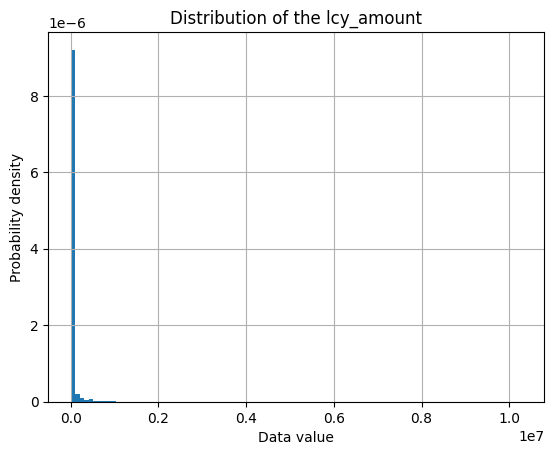

In [12]:
plt.hist(df.lcy_amount, bins=100, density=True)
plt.xlabel('Data value')
plt.ylabel('Probability density')
plt.title('Distribution of the lcy_amount')
plt.grid(True)
plt.show()

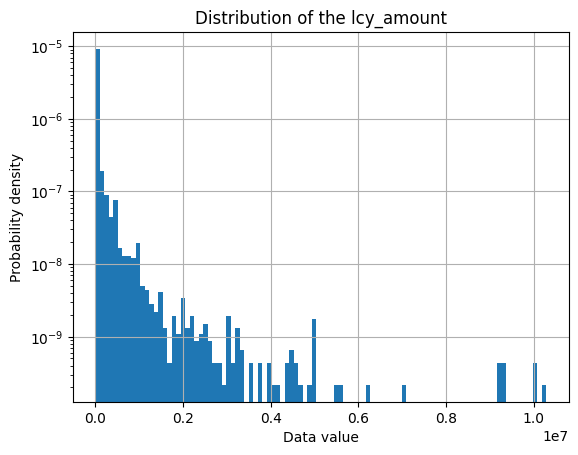

In [13]:
plt.hist(df.lcy_amount, bins=100, density=True) 
plt.xlabel('Data value')
plt.ylabel('Probability density')
plt.title('Distribution of the lcy_amount')
plt.yscale('log')
plt.grid(True)
plt.show()

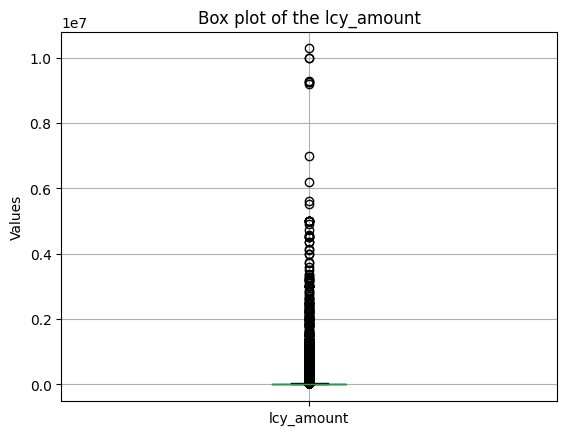

In [14]:
df.boxplot(column='lcy_amount')
plt.ylabel('Values')
plt.title('Box plot of the lcy_amount')
plt.show()

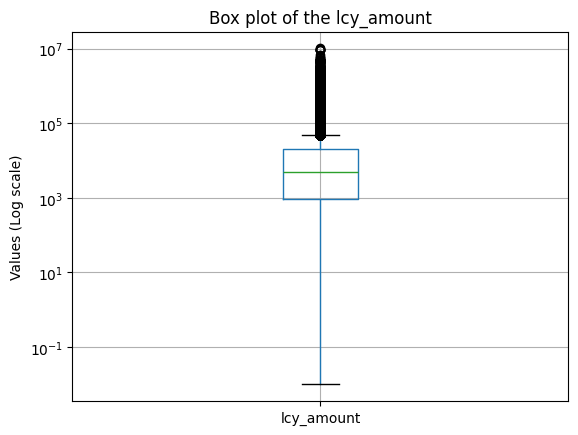

In [15]:
df.boxplot(column='lcy_amount')
plt.ylabel('Values (Log scale)')
plt.yscale('log')
plt.title('Box plot of the lcy_amount')
plt.show()

In [16]:
def iqr_outliers(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return len(df[df[col] < lower_bound]), len(df[df[col] > upper_bound])

lt_iqr_outlier, ut_iqr_outlier = iqr_outliers(df.copy(), 'lcy_amount')
print(f"Number of lower tail iqr outliers:{lt_iqr_outlier}\nNumber of upper tail iqr outliers: {ut_iqr_outlier}")

Number of lower tail iqr outliers:0
Number of upper tail iqr outliers: 4741


In [17]:
def z_score_outliers(df, col):
  mean = df[col].mean()
  std = df[col].std()
  lower_bound = mean - 3* std
  upper_bound = mean + 3* std
  return len(df[df[col] < lower_bound]), len(df[df[col] > upper_bound])

lt_z_outlier, ut_z_outlier = z_score_outliers(df.copy(), 'lcy_amount')
print(f"Number of lower tail z score outliers:{lt_z_outlier}\nNumber of upper tail z score outliers: {ut_z_outlier}")

Number of lower tail z score outliers:0
Number of upper tail z score outliers: 426


In [18]:
branches = df['branch']

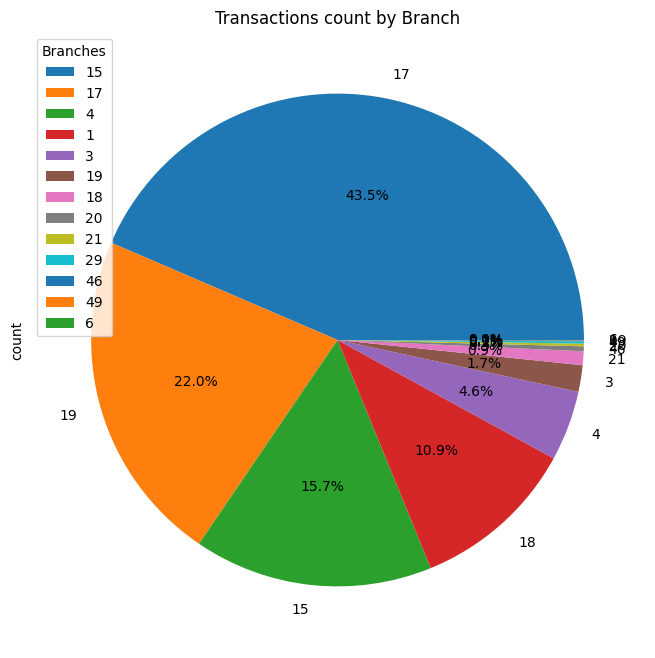

In [19]:
plt.figure(figsize=(8, 8)) 
df['branch'].value_counts().plot(kind='pie', autopct='%1.1f%%', label=None)
plt.title('Transactions count by Branch')
plt.legend(df['branch'].unique(), title='Branches',loc = 'upper left')
plt.show()

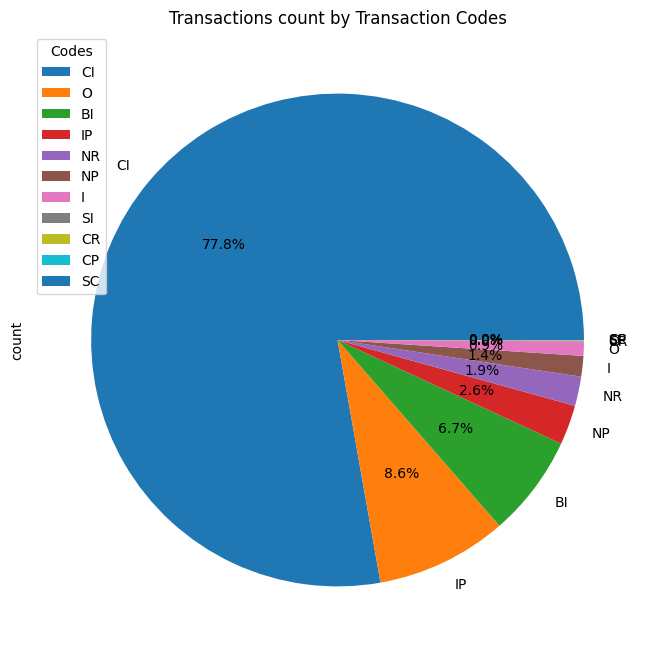

In [20]:
plt.figure(figsize=(8, 8))
df['transaction_code'].value_counts().plot(kind='pie', autopct='%1.1f%%', label=None)
plt.title('Transactions count by Transaction Codes')
plt.legend(df['transaction_code'].unique(), title='Codes',loc = 'upper left')
plt.show()

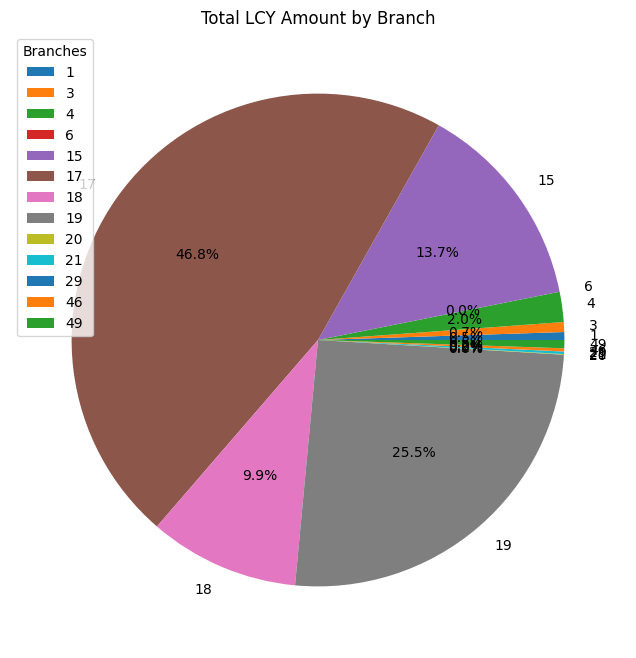

In [21]:
branch_totals = df.groupby('branch')['lcy_amount'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(branch_totals['lcy_amount'], autopct='%1.1f%%', labels=branch_totals['branch'])
plt.title('Total LCY Amount by Branch')
plt.legend(branch_totals['branch'].unique(), title='Branches',loc = 'upper left') 
plt.show()

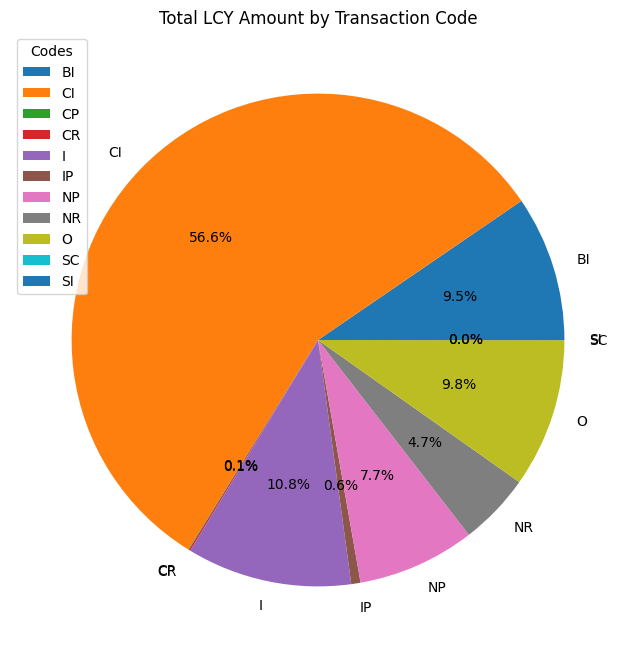

In [22]:
branch_totals = df.groupby('transaction_code')['lcy_amount'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(branch_totals['lcy_amount'], autopct='%1.1f%%', labels = branch_totals['transaction_code'])
plt.title('Total LCY Amount by Transaction Code')
plt.legend(branch_totals['transaction_code'].unique(), title='Codes',loc = 'upper left') 
plt.show()

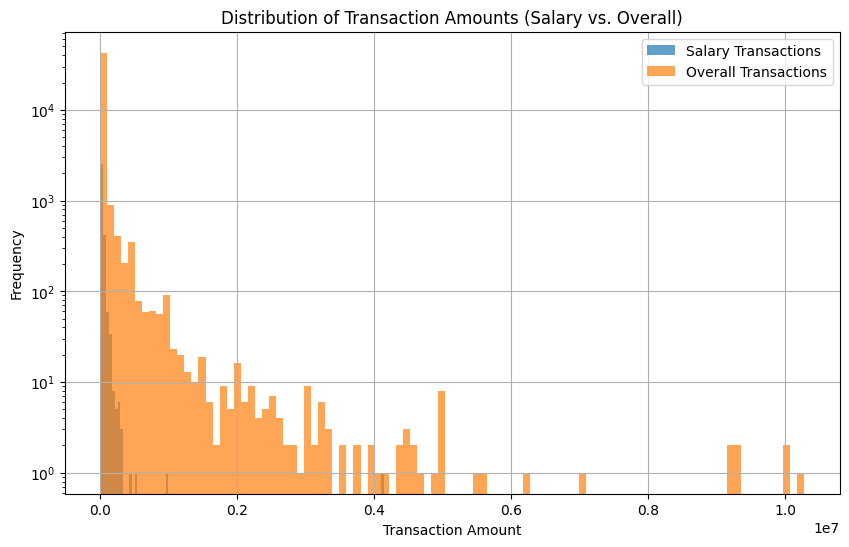

In [23]:
salary_amounts = df[df['is_salary'] == 1]['lcy_amount']

overall_amounts = df['lcy_amount']
plt.figure(figsize=(10, 6))
plt.hist(salary_amounts, bins=100, alpha=0.7, label='Salary Transactions')
plt.hist(overall_amounts, bins=100, alpha=0.7, label='Overall Transactions')
plt.legend()
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Transaction Amounts (Salary vs. Overall)')
plt.grid(True)
plt.show()

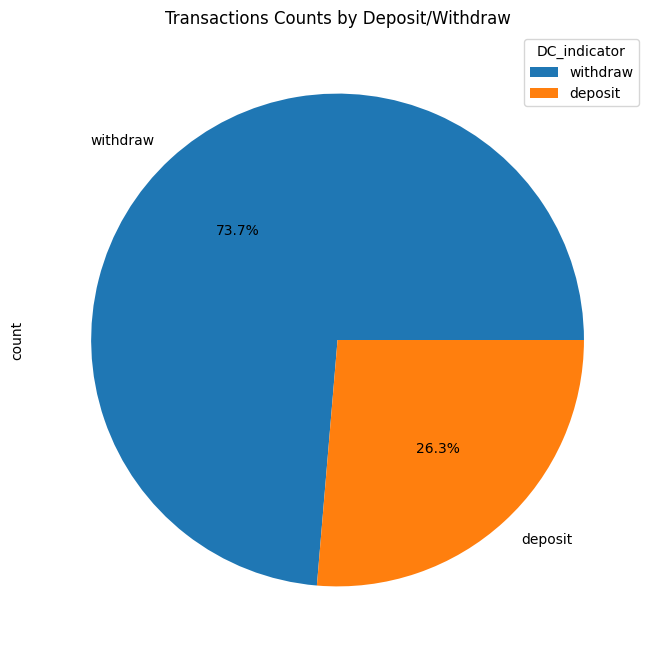

In [24]:
plt.figure(figsize=(8, 8))
df['dc_indicator'].value_counts().plot(kind='pie', autopct='%1.1f%%', label=None)
plt.title('Transactions Counts by Deposit/Withdraw')
plt.legend(df['dc_indicator'].unique(), title='DC_indicator')
plt.show()

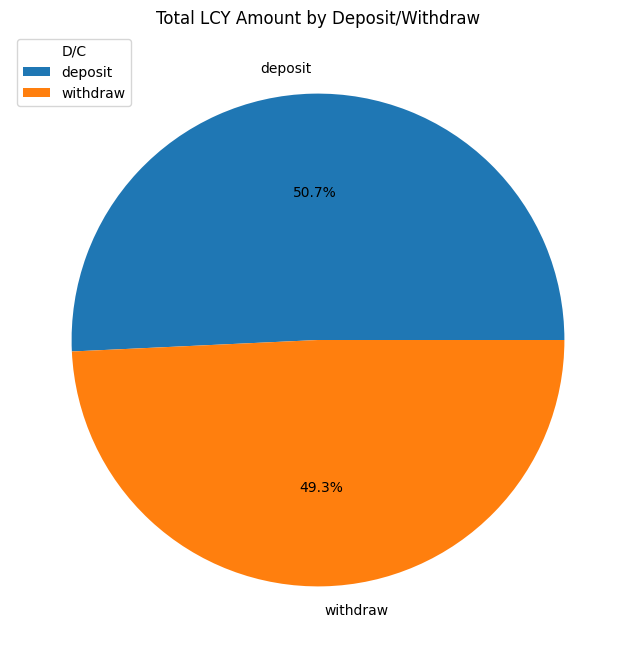

In [25]:
dc_totals = df.groupby('dc_indicator')['lcy_amount'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(dc_totals['lcy_amount'], autopct='%1.1f%%', labels = dc_totals['dc_indicator'])
plt.title('Total LCY Amount by Deposit/Withdraw')
plt.legend(dc_totals['dc_indicator'].unique(), title='D/C',loc = 'upper left') 
plt.show()

In [26]:
branch_amounts = df.groupby('branch')['lcy_amount']

In [27]:
branch_amounts.describe()

,count,mean,std,min,25%,50%,75%,max
branch,,,,,,,,
1,28.0,329377.668214,414663.902255,1134.64,24650.0000,68500.000,625000.000,1500000.00
3,785.0,14852.214726,39883.889902,0.01,490.0000,3500.000,15000.000,500000.00
4,2071.0,17093.419483,49482.398118,0.12,500.0000,5000.000,18081.500,1000000.00
6,2.0,14.460000,18.497913,1.38,7.9200,14.460,21.000,27.54
15,7057.0,34816.792589,147832.075601,0.01,720.8500,5000.000,20000.000,3152898.01
17,19607.0,42805.062682,282414.329233,0.01,701.6150,4623.080,20000.000,10280809.93
18,4887.0,36140.088744,208740.753266,0.02,800.0000,5000.000,20000.000,9282087.29
19,9888.0,46292.613983,193727.696336,0.02,1409.9775,7651.025,25000.000,5600000.00
20,79.0,8673.710633,12748.633972,156.56,2185.0000,5000.000,5495.855,54022.71


From the above data, we can deduce the following informations.

* Branch 1 has the highest average transaction amount despite relatively fewer counts of transactions. Similar case for branch 49.
* Branch 6 has only 2 transactions and of insignificant amount as compared to overall transaction amounts.
* Branch 17, has widely varying transaction amounts. Maybe due to the large number of transactions that take place on this branch as well as this branch contains the lowest minimum transaction amount and also the highest maximum transaction amount.

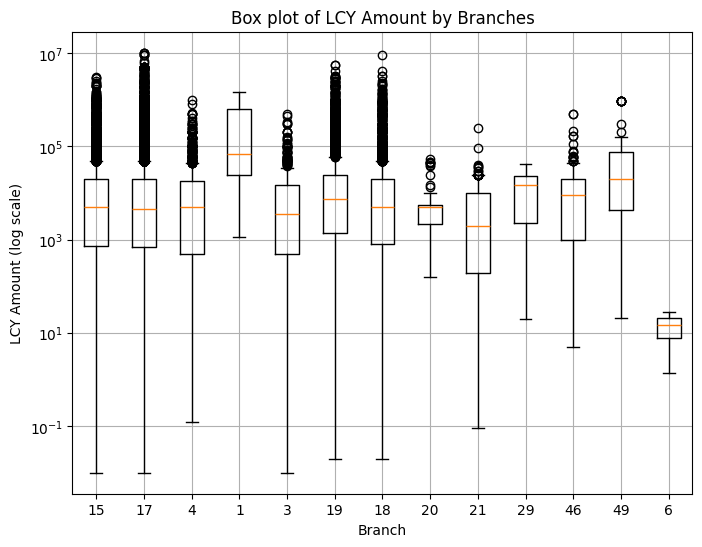

In [28]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['branch'] == code]['lcy_amount'] for code in df['branch'].unique()], labels=df['branch'].unique())
plt.yscale('log')
plt.xlabel('Branch')
plt.ylabel('LCY Amount (log scale)')
plt.title('Box plot of LCY Amount by Branches')
plt.grid(True)
plt.show()

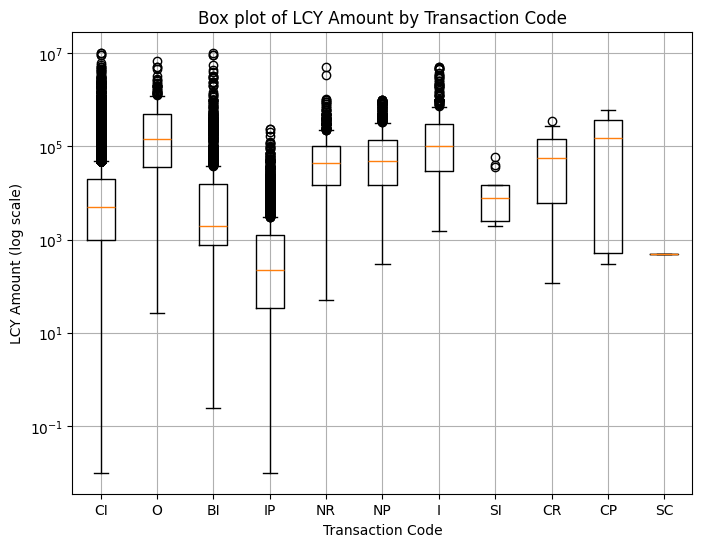

In [29]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['transaction_code'] == code]['lcy_amount'] for code in df['transaction_code'].unique()], labels=df['transaction_code'].unique())
plt.yscale('log') 
plt.xlabel('Transaction Code')
plt.ylabel('LCY Amount (log scale)')
plt.title('Box plot of LCY Amount by Transaction Code')
plt.grid(True)
plt.show()

Transaction code of CP and SR seem to have no iqr outliers. SC contains only one value, thus it is is trivially given that it has no outliers. Cr and SI also has relatively few number of outliers. Looking from a broad perspective, this might be related to SI,CR,CP and SC having very few number of transaction counts.

In [30]:
contingency_table = pd.crosstab(df['branch'], df['transaction_code'])

row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
print(contingency_table.to_string())

transaction_code    BI     CI  CP  CR    I    IP   NP   NR    O  SC  SI
branch                                                                 
1                    0     17   0   0    1     2    6    0    2   0   0
3                   24    666   0   2    6    71    6    7    3   0   0
4                  221   1500   0   0   20   209   64   43   14   0   0
6                    0      0   0   0    0     2    0    0    0   0   0
15                 298   5574   0   0   89   726  152  122   96   0   0
17                1992  14770   0   7  250  1414  618  371  173   0  12
18                 193   3859   0   6   74   481  135   92   46   1   0
19                 269   8032   4   6  157   929  184  224   79   0   4
20                   0     76   0   0    1     2    0    0    0   0   0
21                   3    368   0   0    1    28    3    3    0   0   0
29                   0      6   0   0    0     2    0    0    2   0   0
46                   9    107   0   0    7    11    4    5    3 

Here for every branch, we can see customer initiated transactions occupy the largest percentage of total transaction counts.

In [31]:
code_amounts = df.groupby('transaction_code')['lcy_amount']
code_amounts.describe()

,count,mean,std,min,25%,50%,75%,max
transaction_code,,,,,,,,
BI,3009.0,56885.508657,384511.337153,0.25,757.00,2000.00,15987.89,10000000.00
CI,35029.0,28977.465910,183173.238696,0.01,1000.00,5000.00,20000.00,10280809.93
CP,4.0,225225.000000,286993.175006,300.00,525.00,150300.00,375000.00,600000.00
CR,21.0,93553.560952,104590.411484,119.80,6244.50,55396.00,141610.00,360150.00
I,608.0,319258.557418,675622.351222,1547.90,30000.00,100000.00,300000.00,5000000.00
IP,3881.0,2814.459170,10948.565478,0.01,34.66,220.63,1272.42,238541.10
NP,1172.0,118118.989761,180355.824564,300.00,15000.00,50000.00,138250.00,999000.00
NR,868.0,97603.404954,240403.438229,50.00,15000.00,43242.00,100000.00,5000000.00
O,422.0,415136.630213,709532.035208,26.60,36037.50,144000.00,507700.00,7000000.00


In [32]:
test = df[['description1','transaction_code','is_salary','dc_indicator','branch']]

In [33]:
desc_code_salary = test[test['is_salary'] == 1]
desc_code_salary

,description1,transaction_code,is_salary,dc_indicator,branch
30,2077 Jestha Salary,CI,1,deposit,15
55,SALARY Jestha 76-77,BI,1,deposit,17
65,Jestha Salary,CI,1,deposit,17
218,Jestha Salary,CI,1,deposit,15
221,SALARY,CI,1,deposit,15
...,...,...,...,...,...
45001,SALARY SHRAWAN 77,CI,1,deposit,18
45002,SALARY SHRAWAN 77,CI,1,deposit,18
45003,SALARY SHRAWAN 77,CI,1,deposit,18
45004,SALARY SHRAWAN 77,CI,1,deposit,17


In [34]:
desc_code_salary.isnull().sum()

description1        0
transaction_code    0
is_salary           0
dc_indicator        0
branch              0
dtype: int64

In [35]:
desc_code_salary.transaction_code.value_counts()

transaction_code
CI    2748
BI     297
NR      13
IP       7
O        4
Name: count, dtype: int64

In [36]:
def count_salary(col):
  count = 0
  for i in col:
    if 'salary' in i.lower() or 'sal ' in i.lower()  or 'pension' in i.lower():
      count +=1
  return count

In [37]:
def count_len(code):
  return len(df[df['transaction_code'] == code])

In [38]:
per = count_salary(desc_code_salary.description1)/len(desc_code_salary) * 100
per

94.94949494949495

In [39]:
def extract_first_two_words(text):
    if isinstance(text, str):
        text = re.sub(r'([^\w\s])','', text)
        words = text.split() 
        if len(words) < 2:
            return words[0] if words else '' 
        return ' '.join(words[:2])
    elif pd.isna(text):
        return text
    else:
        return str(text)

In [40]:
test['desc'] = test['description1'].apply(extract_first_two_words)
# test.drop(['description1'], axis=1, inplace=True)

In [41]:
test = test.dropna()
test['desc'] = test['desc'].str.lower()

In [42]:
filtered_df = test[test['desc'].str.contains('leave', case=False, na=False)]

In [43]:
filtered_df['dc_indicator'].value_counts()

dc_indicator
deposit     109
withdraw      2
Name: count, dtype: int64

In [44]:
test['desc'] = test['desc'].str.lower()
test['desc'] = test['desc'].str.replace(' ', '')
test['desc'] = test['desc'].str.strip()
text = ' '.join(test['desc'].tolist())

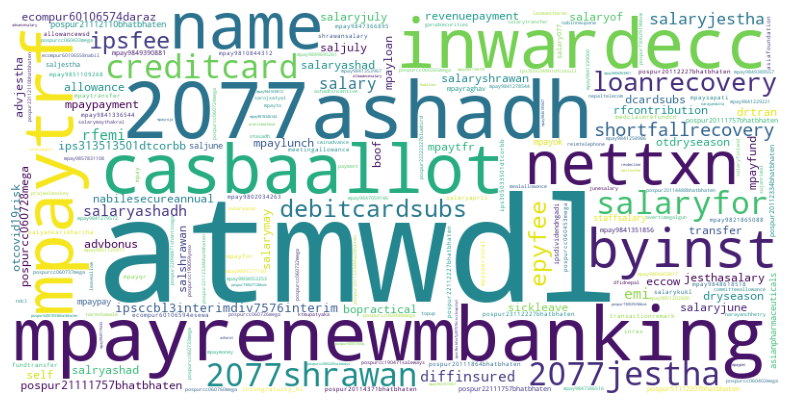

In [45]:
wordcloud = WordCloud(width=800, height=400, background_color='white',collocations=False).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [46]:
atm = test[test['desc'] == 'atmwdl']

In [47]:
atm.dc_indicator.value_counts()

dc_indicator
withdraw    12589
deposit        73
Name: count, dtype: int64

In [48]:
atm.transaction_code.value_counts()

transaction_code
CI    12662
Name: count, dtype: int64

In [49]:
atm.branch.value_counts()

branch
17    4792
19    3281
15    2231
18    1470
4      484
3      234
21     110
46      23
49      21
20       7
1        5
29       4
Name: count, dtype: int64

In [50]:
a = test[test['desc'] == 'atm wdl']
a[a['dc_indicator'] == 'deposit']

,description1,transaction_code,is_salary,dc_indicator,branch,desc


In [51]:
atm.transaction_code.value_counts()

transaction_code
CI    12662
Name: count, dtype: int64

In [52]:
creditc = test[test['desc'] == 'creditcard']

In [53]:
creditc.dc_indicator.value_counts()

dc_indicator
withdraw    403
Name: count, dtype: int64

In [54]:
creditc.transaction_code.value_counts()

transaction_code
BI    403
Name: count, dtype: int64

In [55]:
mrenew = test[test['desc'] == 'mpayrenewmbanking']

In [56]:
mrenew.branch.value_counts()

branch
17    273
15    161
18    103
19     98
4      65
3      16
46      3
49      1
29      1
20      1
Name: count, dtype: int64

In [57]:
mrenew.dc_indicator.value_counts()

dc_indicator
withdraw    722
Name: count, dtype: int64

In [58]:
mrenew.transaction_code.value_counts()

transaction_code
CI    722
Name: count, dtype: int64

In [59]:
mpay = test[test['desc'] == 'mpaytrf']

In [60]:
mpay.dc_indicator.value_counts()

dc_indicator
withdraw    418
deposit     186
Name: count, dtype: int64

In [61]:
mpay.transaction_code.value_counts()

transaction_code
CI    604
Name: count, dtype: int64

In [62]:
inwdec = test[test['desc'] == 'inwardecc']

In [63]:
inwdec.dc_indicator.value_counts()

dc_indicator
withdraw    605
Name: count, dtype: int64

In [64]:
inwdec.transaction_code.value_counts()

transaction_code
I    605
Name: count, dtype: int64

In [65]:
casba = test[test['desc'] == 'casbaallot']
len(casba)

595

In [66]:
casba.dc_indicator.value_counts()

dc_indicator
withdraw    595
Name: count, dtype: int64

In [67]:
casba.transaction_code.value_counts()

transaction_code
BI    595
Name: count, dtype: int64

In [68]:
loanrecov = test[test['desc'] == 'loanrecovery']

In [69]:
loanrecov.dc_indicator.value_counts()

dc_indicator
withdraw    371
Name: count, dtype: int64

In [70]:
loanrecov.transaction_code.value_counts()

transaction_code
CI    371
Name: count, dtype: int64

In [71]:
a = test[test['dc_indicator']== 'deposit']

In [72]:
a.desc.value_counts()

desc
2077ashadh                      799
byinst                          424
2077jestha                      406
2077shrawan                     402
name                            402
                               ... 
0210017503731intpd13042020to      1
0210017559637intpd13042020to      1
0210017526394intpd13042020to      1
0210017539874intpd13042020to      1
0210017559076intpd16072020to      1
Name: count, Length: 4634, dtype: int64

In [73]:
df1 = df[['account_number','dc_indicator','lcy_amount']]
df1

,account_number,dc_indicator,lcy_amount
0,02XYZXYZ10017529992,withdraw,14500.00
1,02XYZXYZ10017529992,withdraw,20000.00
2,02XYZXYZ10017517823,withdraw,4000.00
3,02XYZXYZ10017517823,withdraw,500.00
4,02XYZXYZ10017517823,withdraw,5000.00
...,...,...,...
45026,02XYZXYZ10017509810,withdraw,1000.00
45027,02XYZXYZ100172122201,withdraw,1000.00
45028,02XYZXYZ10017520310,withdraw,5000.00
45029,02XYZXYZ10017559076,deposit,0.38


In [74]:
df1.isnull().sum()

account_number    0
dc_indicator      0
lcy_amount        0
dtype: int64

In [75]:
sum_amount = df1.groupby(['account_number','dc_indicator'])['lcy_amount'].sum()
sum_amount = sum_amount.unstack(level=-1, fill_value=0)
sum_amount

dc_indicator,deposit,withdraw
account_number,,
02XYZXYZ10015339701,8342251.07,880323.64
02XYZXYZ10015571501,2464306.18,2463921.59
02XYZXYZ10015571601,57523.48,92.62
02XYZXYZ10015592101,7437593.79,4274895.37
02XYZXYZ10015593701,1022640.78,3165349.23
...,...,...
02XYZXYZ110017507494,31257.37,53020.42
02XYZXYZ110017507511,54526.30,54535.02
02XYZXYZ110017507523,142085.96,264639.54


In [76]:
sum_amount['deposit_to_withdraw_ratio'] = sum_amount['deposit'] / sum_amount['withdraw']
sum_amount

dc_indicator,deposit,withdraw,deposit_to_withdraw_ratio
account_number,,,
02XYZXYZ10015339701,8342251.07,880323.64,9.476346
02XYZXYZ10015571501,2464306.18,2463921.59,1.000156
02XYZXYZ10015571601,57523.48,92.62,621.069747
02XYZXYZ10015592101,7437593.79,4274895.37,1.739831
02XYZXYZ10015593701,1022640.78,3165349.23,0.323074
...,...,...,...
02XYZXYZ110017507494,31257.37,53020.42,0.589535
02XYZXYZ110017507511,54526.30,54535.02,0.999840
02XYZXYZ110017507523,142085.96,264639.54,0.536904


In [77]:
mask =~np.isinf(sum_amount['deposit_to_withdraw_ratio'])
sum_amount = sum_amount[mask]
sum_amount

dc_indicator,deposit,withdraw,deposit_to_withdraw_ratio
account_number,,,
02XYZXYZ10015339701,8342251.07,880323.64,9.476346
02XYZXYZ10015571501,2464306.18,2463921.59,1.000156
02XYZXYZ10015571601,57523.48,92.62,621.069747
02XYZXYZ10015592101,7437593.79,4274895.37,1.739831
02XYZXYZ10015593701,1022640.78,3165349.23,0.323074
...,...,...,...
02XYZXYZ110017507494,31257.37,53020.42,0.589535
02XYZXYZ110017507511,54526.30,54535.02,0.999840
02XYZXYZ110017507523,142085.96,264639.54,0.536904


In [78]:
ratio_counts_sum = {
    'greater_than_1': (sum_amount['deposit_to_withdraw_ratio'] > 1).sum(),
    'less_than_1': (sum_amount['deposit_to_withdraw_ratio'] < 1).sum(),
    'equal_to_1': (sum_amount['deposit_to_withdraw_ratio'] == 0).sum()
}

In [79]:
print(ratio_counts_sum)

total_deposit_value = sum_amount['deposit'].sum()
total_withdraw_value = sum_amount['withdraw'].sum()
print(f"Total Deposit Value: {total_deposit_value}")
print(f"Total Withdraw Value: {total_withdraw_value}")
print(f"Total Ratio: {total_deposit_value/total_withdraw_value}")

{'greater_than_1': 924, 'less_than_1': 904, 'equal_to_1': 0}
Total Deposit Value: 909677119.79
Total Withdraw Value: 883017612.1
Total Ratio: 1.0301913657493174


In [80]:
count_amount = df1.groupby(['account_number','dc_indicator'])['lcy_amount'].count()
count_amount

account_number        dc_indicator
02XYZXYZ10015339701   deposit         13
                      withdraw        15
02XYZXYZ10015571501   deposit          7
                      withdraw        22
02XYZXYZ10015571601   deposit          3
                                      ..
02XYZXYZ110017507523  withdraw        11
02XYZXYZ110017507524  deposit          6
                      withdraw        16
02XYZXYZ110017507568  deposit          4
                      withdraw         4
Name: lcy_amount, Length: 3671, dtype: int64

In [81]:
count_amount = count_amount.unstack(level=-1, fill_value=0)
count_amount

dc_indicator,deposit,withdraw
account_number,,
02XYZXYZ10015339701,13,15
02XYZXYZ10015571501,7,22
02XYZXYZ10015571601,3,1
02XYZXYZ10015592101,5,39
02XYZXYZ10015593701,6,15
...,...,...
02XYZXYZ110017507494,3,16
02XYZXYZ110017507511,10,26
02XYZXYZ110017507523,8,11


In [82]:
count_amount['deposit_to_withdraw_ratio'] = count_amount['deposit'] / count_amount['withdraw']
count_amount

dc_indicator,deposit,withdraw,deposit_to_withdraw_ratio
account_number,,,
02XYZXYZ10015339701,13,15,0.866667
02XYZXYZ10015571501,7,22,0.318182
02XYZXYZ10015571601,3,1,3.000000
02XYZXYZ10015592101,5,39,0.128205
02XYZXYZ10015593701,6,15,0.400000
...,...,...,...
02XYZXYZ110017507494,3,16,0.187500
02XYZXYZ110017507511,10,26,0.384615
02XYZXYZ110017507523,8,11,0.727273


In [83]:
mask =~np.isinf(count_amount['deposit_to_withdraw_ratio'])
count_amount1 = count_amount[mask]
count_amount1

dc_indicator,deposit,withdraw,deposit_to_withdraw_ratio
account_number,,,
02XYZXYZ10015339701,13,15,0.866667
02XYZXYZ10015571501,7,22,0.318182
02XYZXYZ10015571601,3,1,3.000000
02XYZXYZ10015592101,5,39,0.128205
02XYZXYZ10015593701,6,15,0.400000
...,...,...,...
02XYZXYZ110017507494,3,16,0.187500
02XYZXYZ110017507511,10,26,0.384615
02XYZXYZ110017507523,8,11,0.727273


In [84]:
ratio_counts_count = {
    'greater_than_1': (count_amount1['deposit_to_withdraw_ratio'] > 1).sum(),
    'less_than_1': (count_amount1['deposit_to_withdraw_ratio'] < 1).sum(),
    'equal_to_1': (count_amount1['deposit_to_withdraw_ratio'] == 0).sum()
}

In [85]:
print(ratio_counts_count)
total_deposit_count = count_amount['deposit'].sum()
total_withdraw_count = count_amount['withdraw'].sum()
print(f"Total Deposit Counts: {total_deposit_count}")
print(f"Total Withdraw Counts: {total_withdraw_count}")
print(f"Total Ratio: {total_deposit_count/total_withdraw_count}")

{'greater_than_1': 220, 'less_than_1': 1445, 'equal_to_1': 0}
Total Deposit Counts: 11860
Total Withdraw Counts: 33171
Total Ratio: 0.35754122576949743


In [86]:
count_list = count_amount1['deposit_to_withdraw_ratio'].tolist()

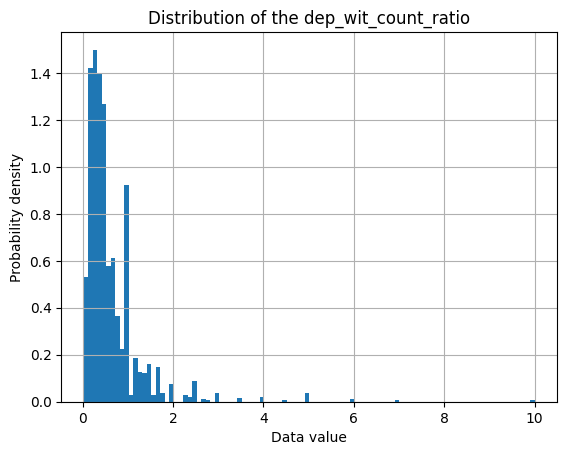

In [87]:
plt.hist(count_amount1.deposit_to_withdraw_ratio,bins = 100, density=True)
plt.xlabel('Data value')
plt.ylabel('Probability density')
plt.title('Distribution of the dep_wit_count_ratio')
plt.grid(True)
plt.show()

In [88]:
sign_test_result = stats.binomtest(sum(np.array(sum_amount.deposit_to_withdraw_ratio) > 1), n = len(sum_amount.deposit_to_withdraw_ratio), p = 0.5, alternative='greater')

print("One-Sample Sign Test:")
print(f"Sign Test statistic: {sign_test_result.statistic}")
print(f"p-value: {sign_test_result.pvalue}")

One-Sample Sign Test:
Sign Test statistic: 0.5040916530278232
p-value: 0.3718392382882549


In [89]:
differences = sum_amount['deposit_to_withdraw_ratio'] - 1

statistic, p_value = stats.wilcoxon(differences, alternative='greater')
print("Wilcoxon Signed Rank Test:")
print(f"Wilcoxon Test statistic: {statistic}")
print(f"p-value: {p_value}")

Wilcoxon Signed Rank Test:
Wilcoxon Test statistic: 959992.0
p-value: 1.8998093323428505e-08


We reject the null hypothesis.


In [90]:
data = df[['branch','lcy_amount']]

In [91]:
def create_buckets(amounts):
    quartiles = pd.qcut(amounts, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    return quartiles

data['buckets'] = create_buckets(data['lcy_amount'])
contingency_table = pd.crosstab(data['branch'], data['buckets'])

In [92]:
contingency_table

buckets,Q1,Q2,Q3,Q4
branch,,,,
1,0,2,2,24
3,240,230,167,148
4,621,539,485,426
6,2,0,0,0
15,1839,1923,1715,1580
17,5199,6046,4017,4345
18,1255,1421,1056,1155
19,1901,2538,2680,2769
20,10,49,11,9


In [93]:
grouped_data = data.groupby(['branch', 'buckets']).size().unstack()
bucket_percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

bucket_percentages

buckets,Q1,Q2,Q3,Q4
branch,,,,
1,0.000000,7.142857,7.142857,85.714286
3,30.573248,29.299363,21.273885,18.853503
4,29.985514,26.026074,23.418638,20.569773
6,100.000000,0.000000,0.000000,0.000000
15,26.059232,27.249539,24.302111,22.389117
17,26.516040,30.835926,20.487581,22.160453
18,25.680377,29.077143,21.608349,23.634131
19,19.225324,25.667476,27.103560,28.003641
20,12.658228,62.025316,13.924051,11.392405


In [94]:
chi2, p_value, dof, x = stats.chi2_contingency(contingency_table)

In [95]:
print(f"Chi-square test for independence:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")

Chi-square test for independence:
Chi-square statistic: 705.8012884551438
P-value: 3.293042199564945e-125
Degrees of freedom: 36


Transaction amount buckets does depend on bank branch.

In [96]:
data1 = df[['account_number','lcy_amount','tran_date']]

In [97]:
data1.set_index('tran_date', inplace=True)

In [98]:
data1

,account_number,lcy_amount
tran_date,,
2020-06-09,02XYZXYZ10017529992,14500.00
2020-06-14,02XYZXYZ10017529992,20000.00
2020-06-01,02XYZXYZ10017517823,4000.00
2020-06-05,02XYZXYZ10017517823,500.00
2020-06-12,02XYZXYZ10017517823,5000.00
...,...,...
2020-08-16,02XYZXYZ10017509810,1000.00
2020-08-16,02XYZXYZ100172122201,1000.00
2020-08-16,02XYZXYZ10017520310,5000.00


In [99]:
aggregated_data = data1.groupby('tran_date')['lcy_amount'].sum()

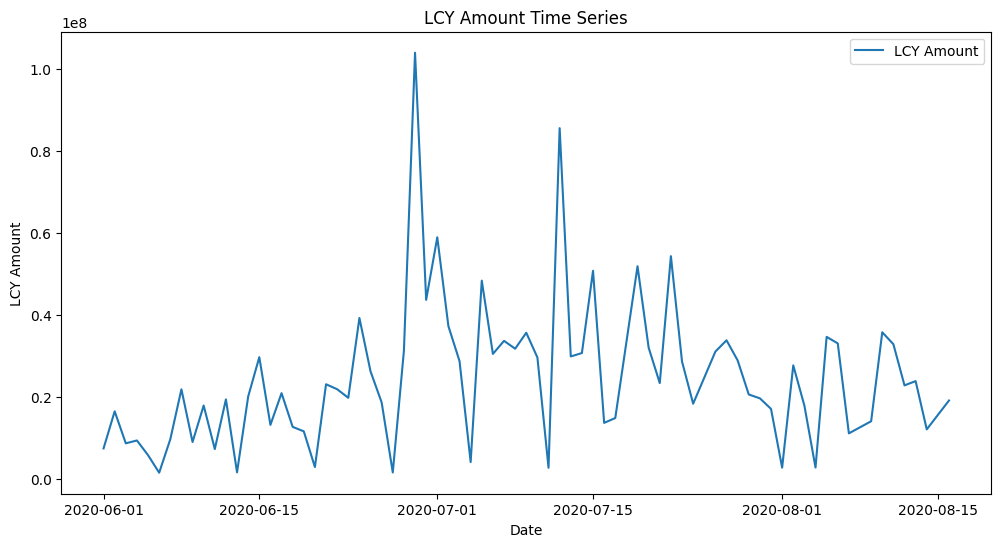

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data, label='LCY Amount')
plt.title('LCY Amount Time Series')
plt.xlabel('Date')
plt.ylabel('LCY Amount')
plt.legend()
plt.show()

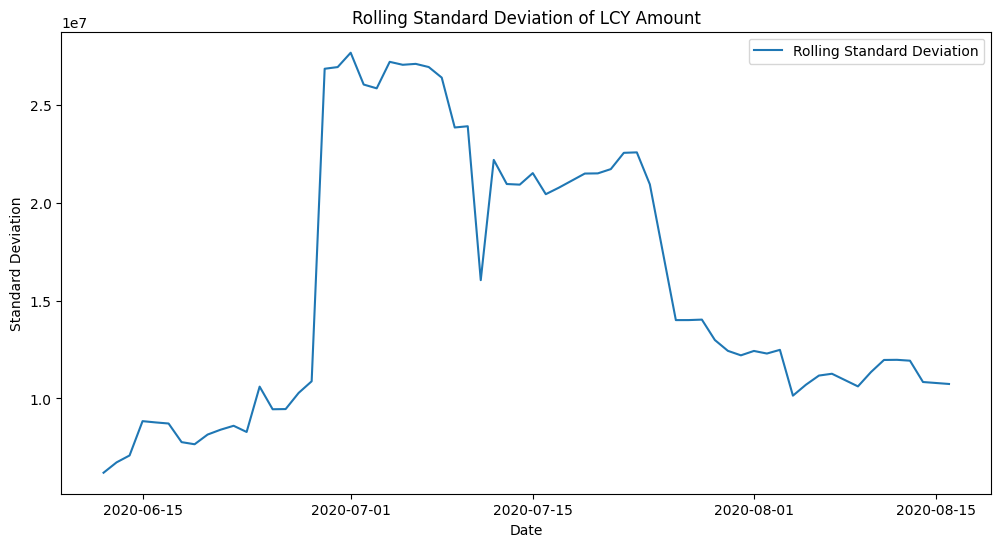

In [101]:
rolling_std = aggregated_data.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(rolling_std, label='Rolling Standard Deviation')
plt.title('Rolling Standard Deviation of LCY Amount')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

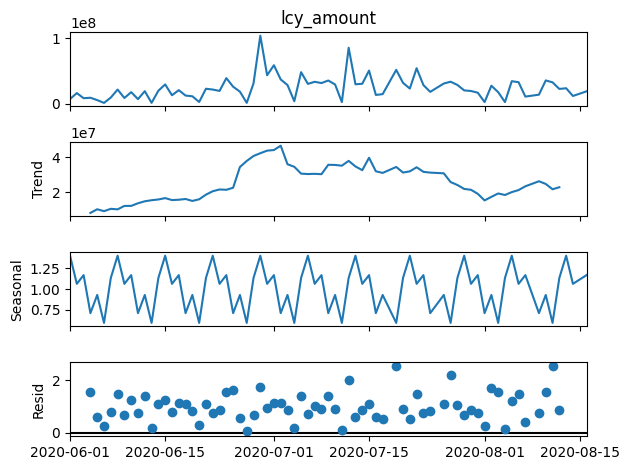

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(aggregated_data, model='multiplicative', period=7)
fig = decomposition.plot()
plt.show()

In [103]:
count_amount1['sum'] = count_amount1['deposit'] + count_amount1['withdraw']
count_amount1

dc_indicator,deposit,withdraw,deposit_to_withdraw_ratio,sum
account_number,,,,
02XYZXYZ10015339701,13,15,0.866667,28
02XYZXYZ10015571501,7,22,0.318182,29
02XYZXYZ10015571601,3,1,3.000000,4
02XYZXYZ10015592101,5,39,0.128205,44
02XYZXYZ10015593701,6,15,0.400000,21
...,...,...,...,...
02XYZXYZ110017507494,3,16,0.187500,19
02XYZXYZ110017507511,10,26,0.384615,36
02XYZXYZ110017507523,8,11,0.727273,19


In [104]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [105]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(count_amount1.reset_index().drop(['account_number','deposit','withdraw'], axis=1))

In [106]:
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(scaled_data) 
count_amount1['cluster'] = kmeans.labels_

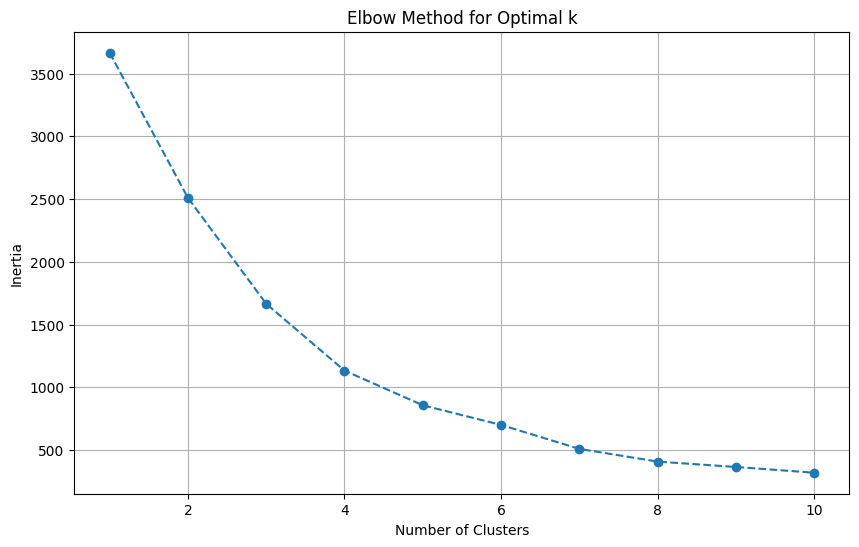

In [108]:
from sklearn.cluster import KMeans
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show() 

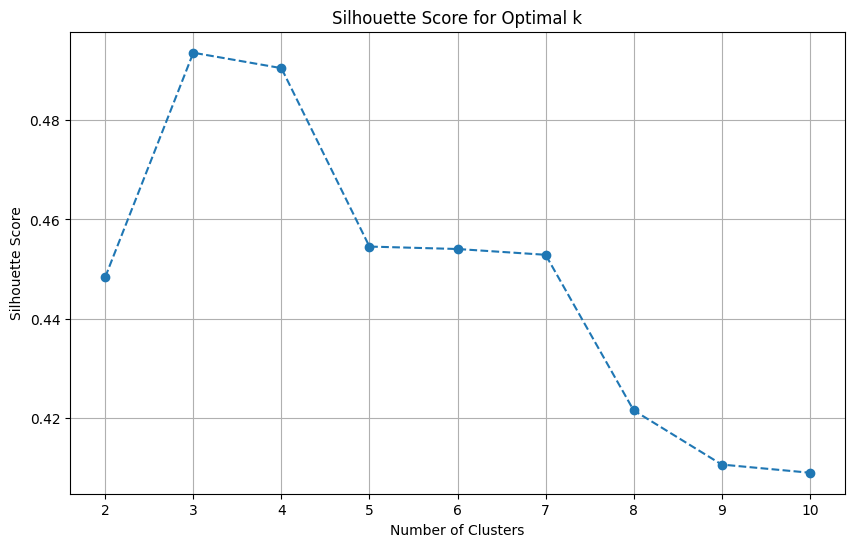

In [109]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()


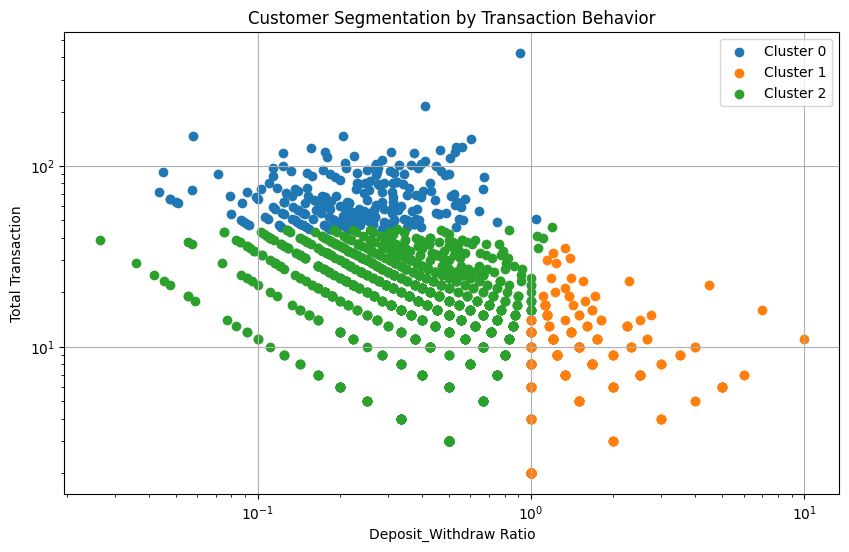

In [107]:
plt.figure(figsize=(10, 6))

for cluster in sorted(count_amount1['cluster'].unique()):
    cluster_data = count_amount1[count_amount1['cluster'] == cluster]
    plt.scatter(cluster_data['deposit_to_withdraw_ratio'], cluster_data['sum'], label=f'Cluster {cluster}')

plt.title('Customer Segmentation by Transaction Behavior')
plt.xlabel('Deposit_Withdraw Ratio')
plt.ylabel('Total Transaction')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()
